# Fundamentals of Machine Learning - 2022
## Report 1 - Classification task
Pablo Chehade  
Última modificación: 10/09/2022


### Introducción

El objetivo es construir un modelo de machine learning que sea capaz de predecir el target de un problema lo mejor posible.  
- TARGET: clase de árbol más frecuente en una celda de 30m por 30m que contiene distintos tipos de árboles
- PREDICTOR VARIABLES: info. geográfica sobre tal celda, como por ejemplo pendiente del suelo, distacia a cuerpos de agua o posibles fire sports, etc.  

Para tal fin se puede experimentar con solo dos modelos: random forests y xgboost  

- Plantear una descripción gral de los modelos que se pueden utilizar
- Dar una especie de orden en el cual se irán atacando los problemas

En primer lugar, se realizó un análisis exploratorio de los datos

In [1]:
#Importo librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split #Para dividir el dataset en 2 partes


### Análisis Exploratorio de los Datos

#### Primer vistazo a los datos

In [2]:
#Importo el dataset con pandas
data = pd.read_csv('datasets/train_r1.csv')

In [3]:
#Imprimo las primeras columnas
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2


In [4]:
#Imprimo info gral del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464810 entries, 0 to 464809
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   altura                464810 non-null  int64
 1   exposicion            464810 non-null  int64
 2   inclinacion_suelo     464810 non-null  int64
 3   distancia_agua        464810 non-null  int64
 4   altura_agua           464810 non-null  int64
 5   distancia_caminos     464810 non-null  int64
 6   sombra_maniana        464810 non-null  int64
 7   sombra_mediodia       464810 non-null  int64
 8   sombra_tarde          464810 non-null  int64
 9   distancia_fuego       464810 non-null  int64
 10  clase_area_silvestre  464810 non-null  int64
 11  clase_suelo           464810 non-null  int64
 12  dosel_forestal        464810 non-null  int64
dtypes: int64(13)
memory usage: 46.1 MB


In [5]:
#data["clase_area_silvestre"].value_counts()
#data["clase_suelo"].value_counts()
data["dosel_forestal"].value_counts()

2    226596
1    169395
3     28602
7     16406
6     13993
5      7614
4      2204
Name: dosel_forestal, dtype: int64

##### Observaciones

Se tienen 12 variables predictoras y 1 target (clase_forestal). Tipos de variables:
- Las variables exposicion (columna 2) e inclinacion_suelo (columna 3) se encuentran en grados.
- Las variables sombra_maniana (columna 7), sombra_mediodia (columna 8) y sombra_tarde (columna 9) son enteros en el intervalo [0,255].
- Las variables clase_area_silvestre (columna 11), clase_suelo (columna 12) y dosel_forestal (columna 13) son categóricas. La primera tiene 4 categorías, la 2da, 40 y la 3ra, 7. Los nros enteros representan clases.  
- El resto de variables son distancias en metro  

Datos nulos: No hay datos nulos en el dataset.

#### Separo entre Train y Test

Tengo que poner en test_size al menos un nro bien pequeño cosa de que haga el random sobre el train_set

In [6]:
#Divido el dataset entre train y test. A partir de ahora no utilizaré test
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42) ### Fijamos 20% para test y 42 es el random state para poder reproducir los resultados.

#Guardo el test set en un archivo pickle
test_set.to_pickle("datasets/data_test.pkl")

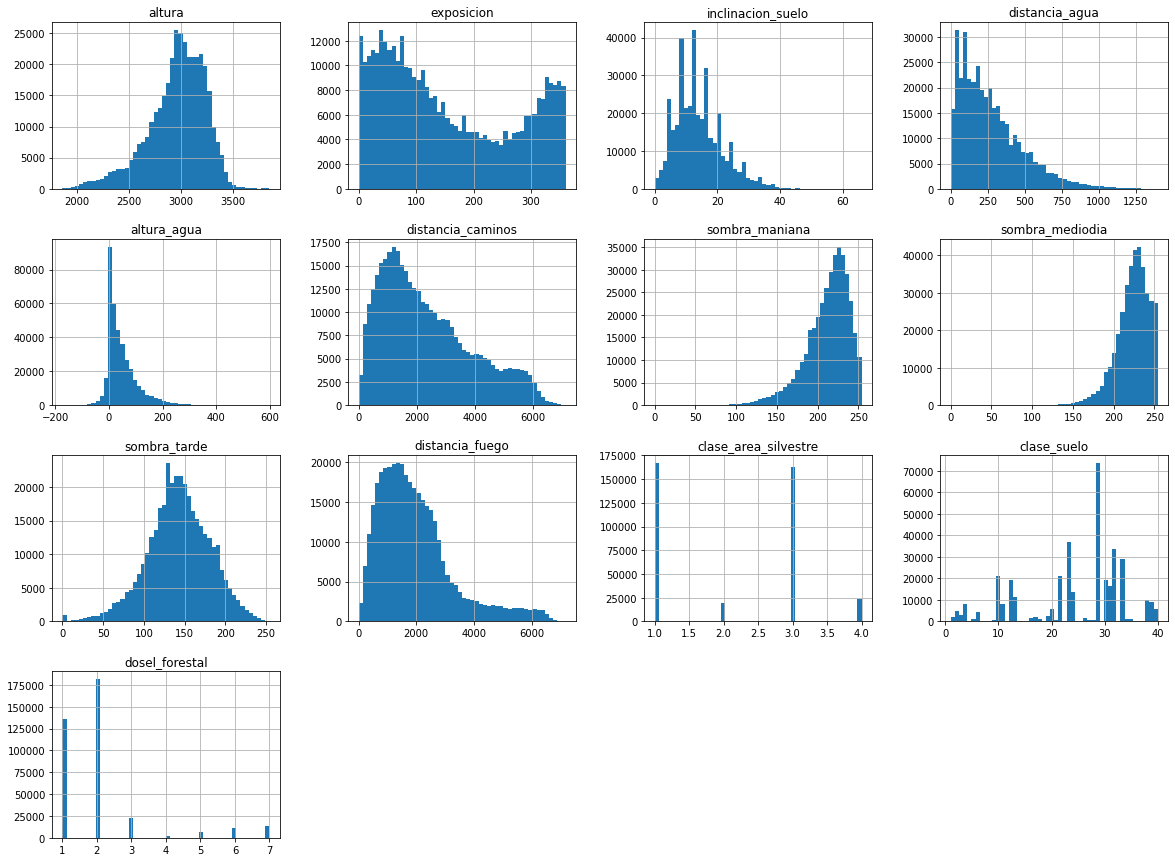

In [7]:
#Hago un histograma de cada atributo
train_set.hist(bins=50, figsize=(20,15));


In [8]:
#Analizo correlaciones entre atributos
corr_matrix = train_set.corr()
#plt.matshow(corr_matrix) #No aporta mucha info. la matriz de correlaciones

corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                 -0.268298
clase_suelo            -0.163547
distancia_caminos      -0.152848
distancia_fuego        -0.108455
sombra_mediodia        -0.095722
sombra_tarde           -0.048833
sombra_maniana         -0.034310
distancia_agua         -0.021745
exposicion              0.017364
altura_agua             0.080170
inclinacion_suelo       0.147542
clase_area_silvestre    0.276400
dosel_forestal          1.000000
Name: dosel_forestal, dtype: float64


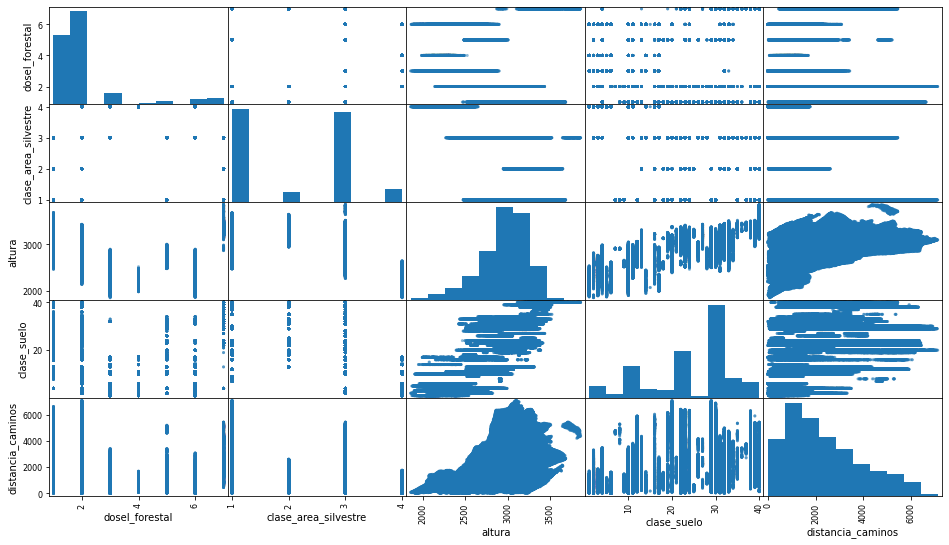

In [9]:
#Las correlaciones de mayor módulo son clase_area_silvestre, altura, clase_suelo, distancia_caminos e inclinacion_suelo.

feat_corr = ["dosel_forestal","clase_area_silvestre", "altura", "clase_suelo", "distancia_caminos"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

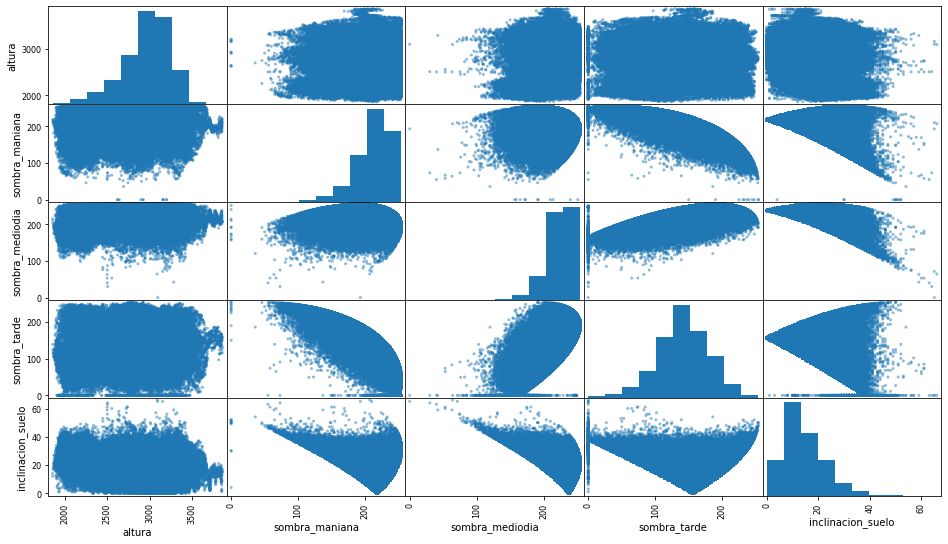

In [10]:
#Intuitivamente, también esperaría que las variables altura, las tres de sombra e inclinacion_suelo estén correlacionadas. Me fijo si realmente es así
feat_corr = ["altura", "sombra_maniana", "sombra_mediodia", "sombra_tarde", "inclinacion_suelo"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

##### Observaciones

- De los histogramas se obtiene que hay variables con distribución sesgada, tal como inclinacion_suelo, distancia_agua, entre otras. Pero tmb existen otras simétricas, como sombra_tarde. Por otro lado, no son de gran utilidad los histogramas de las variables categóricas, salvo para ver la proporción de datos para cada categoría. En el caso de la variable target dosel_forestal, la clase 2 está en mayor proporción que las demás. Mientras que la clase 4 es la de menor proporción.
- De la matriz de correlación se obtiene que
* Las comparaciones entre variables categóricas no son muy útiles. La única info. que se obtiene es que existen datos que pertenecen a una determinada categoría de una variable pero nunca pertenecen a una determinada categoría de otra variable. Por ej, parece no haber datos en la categoría 3 de dosel_forestal y categoría 2 de clase_area_silvestre. Quizás podríamos obtener mayor información si supiéramos qué significa cada categoría.
* Altura y clase_suelo parecen estar correlacionadas.
* Altura y distancia_caminos. Podríamos crear una nueva variable que sea el cociente entre la variable distancia_caminos y altura.
* Las variables de sombra tienen correlación entre sí, pero no se observa una clara correlación de las mismas con altura. Podría crear una variable que sea media de sombra_maniana, sombra_mediodia y sombra_tarde.

In [11]:
#Creo nuevas variables
sombra_mean = (train_set["sombra_maniana"] + train_set["sombra_mediodia"] + train_set["sombra_tarde"])/3
train_set["sombra_mean"] = sombra_mean

razon_distcaminos_altura = train_set["distancia_caminos"]/train_set["altura"]
train_set["razon_distcaminos_altura"] = razon_distcaminos_altura

#Analizo nuevamente las correlaciones
corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                     -0.268298
clase_suelo                -0.163547
distancia_caminos          -0.152848
razon_distcaminos_altura   -0.142516
distancia_fuego            -0.108455
sombra_mean                -0.107742
sombra_mediodia            -0.095722
sombra_tarde               -0.048833
sombra_maniana             -0.034310
distancia_agua             -0.021745
exposicion                  0.017364
altura_agua                 0.080170
inclinacion_suelo           0.147542
clase_area_silvestre        0.276400
dosel_forestal              1.000000
Name: dosel_forestal, dtype: float64


##### Observaciones

La nueva variable sombra_mean tiene ligeramente mayor correlación que las variables sombra_maniana, sombra_mediodia y sombra_tarde por separado
La nueva variable razon_distcaminos_altura tiene menor correlación en módulo que distancia_caminos.

In [12]:
#Guardo los datos
train_set.to_pickle("datasets/data_train.pkl")

### Modelos

In [13]:
#Divido el train_set entre train_predictors y train_target
train_predictors = train_set.drop("dosel_forestal", axis=1)
train_target = train_set["dosel_forestal"].copy()



#### Random Forest

Los árboles son robustos a la no normalización, por lo que no es necesario hacer standarización. Además, no hay missing values en los datos, por lo que no hay que trabajar con NaNs.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 100, max_depth = 10, min_samples_split = 2, min_samples_leaf = 1)
#Lo entreno
RFmodel.fit(train_predictors, train_target)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

##### Gráfico para ver qué tan bueno es el modelo

El objetivo es ver cuán bien ajusta el modelo a los datos de train. Esto puede llegar a no ser tan visible porque muchas variables son categóricas. De hecho, las variables con mayor correlación con el target son clase_area_silvestre (categórica) y altura (continua).



c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 61.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 63.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\seaborn\categorical.py:3540: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

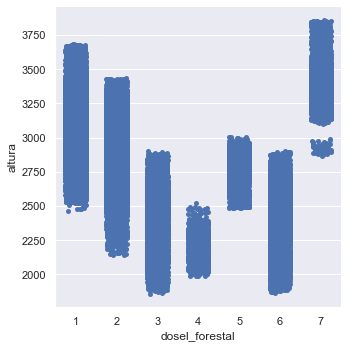

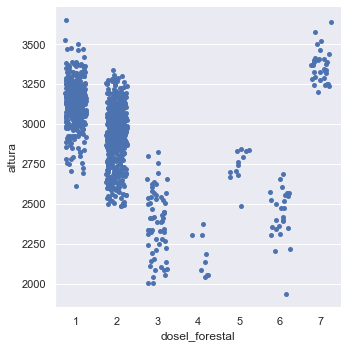

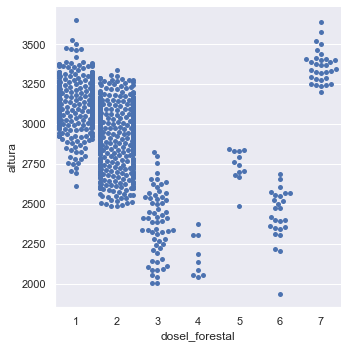

In [15]:
import seaborn as sns

# Apply the default theme
sns.set_theme()
#El siguiente gráfico está bueno pero es poco representativo porque no se pueden ver bien los datos (son muchos)
sns.catplot(data=train_set, x="dosel_forestal", y="altura", jitter=0.25);
#Podemos hacer el mismo gráfico pero con una porción más pequeña del train set:
train_set_small = train_set.iloc[:1000] #Si bien los índices van de 0 a 1000, son aleatorios porque en la división entre train y test se mezclaron los datos.

#En el siguiente gráfico, la separación respecto a la vertical sólo se emplea para separar los puntos, no está asignado a ninguna variable
sns.catplot(data=train_set_small, x="dosel_forestal", y="altura", jitter=0.25);
#En el siguiente gráfico, la separación es tal que intenta no superponer puntos. Está buena pero no es útil para muchos datos.
sns.catplot(data=train_set_small, x="dosel_forestal", y="altura", kind="swarm");

#Me quedo con el primer gráfico. Pero para que sea representativo voy a hacerlo sobre varios conjuntos de train_set_small. La diferencia es enorme de todos modos. En los gráficos tomo solo 1.000 datos, cuando en la práctica hay cerca de 370.000.


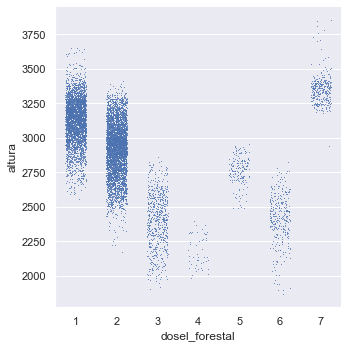

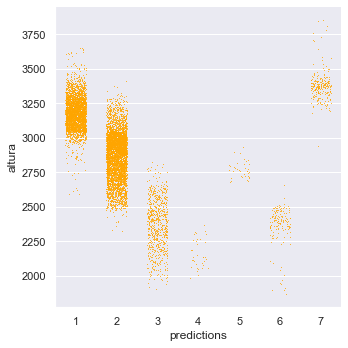

In [16]:
#Hago las predicciones con el modelo
train_predictions = RFmodel.predict(train_predictors)
#Las junto en una nueva columna del train_set
plot_set = train_set.copy()
plot_set["predictions"] = train_predictions

for i in range(1):
    #Divido el set en sets más pequeños
    plot_set_small = plot_set.iloc[10000*i:10000*(1+i)]
    sns.catplot(data=plot_set_small, x="dosel_forestal", y="altura", jitter=0.25, size = 1);
    sns.catplot(data=plot_set_small, x="predictions", y="altura", jitter=0.25, size = 1, color="orange");


In [ ]:
#Error sobre el train set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

RFmodel_mse = mean_squared_error(train_target, RFmodel.predict(train_predictors))
RFmodel_smse = np.sqrt(RFmodel_mse)
print("Square of Mean Square Error: ", RFmodel_mse )

RFmodel_mae = mean_absolute_error(train_target,RFmodel.predict(train_predictors))
print("Mean Absolute Error: ", RFmodel_mae )





Square of Mean Square Error:  0.9580312385705987
Mean Absolute Error:  0.3453723026613025


Con los parámetros por default el modelo tiene error nulo! está overfitteando. Cambiando el parámetro max_depth a 10, el modelo tiene un error asociado y por lo tanto no overfittea (al menos no tanto como antes). Por default la variable max_depth está en None, es decir, los nodos se expanden hasta que las leaves sean puras, de ahí el overfitting quizás.

##### Veo si standarizando mejora 

##### Cross Validation

Para evaluar el desempeño de estos modelos sin utilizar nuestro set de test podemos hacer una nueva división de la partición de training. De la misma manera que antes, separamos una porción de los datos y luego entrenamos con el resto. Lo usual es dividir a los datos en 5 o 10 subconjuntos excluyentes entre sí y separar uno como el nuevo test. Con el resultado del entrenamiento aplicamos el ajuste a los datos separados y evaluamos el modelo con una función de score, por ej MSE. 
Para ver que los resultados no dependen de la partición utilizada volvemos a hacer este procedimiento utilizando los mismos 5 o 10 subconjuntos que habíamos definido, pero ahora elejimos otro para test. Haciendo esto para cada uno de los subconjunots tendremos 5, o 10, evaluaciones del modelo con su score.

In [18]:
from sklearn.model_selection import cross_val_score

### definamos una función para presentar los resultados 
def display_scores(scores):
    print("Scores:", scores) #Score de cada partición
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

In [19]:
train_predictions = RFmodel.predict(train_predictors)
scores = cross_val_score(RFmodel, train_predictors, train_target,scoring="neg_mean_squared_error", cv=5) #cv es la cantidad de particiones
display_scores(np.sqrt(-scores))


Scores: [0.98580076 0.99329472 0.99756325 0.99919289 0.99390362]
Mean: 0.9939510475701535
Standard deviation: 0.0046343295436484175


Nos interesa que los scores sean más o menos parecidos porque si no en algún caso está overfitteando. Uno puede ver esto directamente con el desvío estándard. Si el desvío estándard es grande, sabemos que el modelo es muy sensible a hacer overfitting porque ((se ajusta muy bien a algunos datos y muy mal a otros))


Más aún, tiene menos dispersión, con lo que podemos inferir que el ajuste es similar para cada "fold" (partición) del cross validation. 

##### Grid search

El primer acercamiento a encontrar el mejor conjunto de hiperparámetros consiste en definir una grilla de valores a evaluar y comparar los scores medios del 10-fold CV hasta encontrar el mejor.

Terminé usando 5-fold CV porque si no tardaba mucho la compu

Seguramente lo mejor sea hacer grid search sobre el "mejor modelo", es decir, sobre Radom Forest o XgBoost. Pero como a priori no tengo en claro "la mejor elección de parámetros", prefiero hacer grid search en cada uno de los modelos y luego comparo entre los mejores modelos.

¿Qué parámetros se pueden variar del RandomForest? Hago una lista de los parámetros, junto a una breve explicación, el valor por default y el rango en el que voy a variar cada uno de ellos al hacer grid search

1. n_estimators: nro de trees en el forest  
* Default: 100  
* Variación: [50,100,200]
2. criterion: función para medir el error en el split
* Default: "gini"  
* Variación: ["gini", "entropy", "log_loss"]  
3. max_depth: máxima depth en el tree
* Default = None, es decir, los nodos se expanden hasta que todas las leaves sean puras  
* Variación: [2, 5, 10]
4. min_samples_split: nro minimo de samples necesarios para hacer un split en un nodo interno
* Default: 2
* Variación: [2,4]
5. min:samples_leaf: nro mínimo de samples necesario para estar en un leaf node.
* Default: 1
* Variación: [1,2]
6. max_features: nro de atributos considerados al buscar el mejor split. Sea p la cantidad total de variables.
* Default: sqrt(p)
* Variación: ["sqrt", "log2"]
7. boostrap (bool): usar o no boostraped samples?
* Default: True
* Variación: True
8. oob_score (bool): usar o no out-of-bag samples para estimar el score de generalización
* Default: False
* Variación: True. La mejor opción para evitar overfitting sería elegir el mejor modelo como aquel que sea capaz de generalizar y, por lo tanto, capaz de predecir datos con los que no fue entrenado. En out-of-bag error, se estima el error a partir de los datos que no cayaron en cada boostraped sample en particular.
9. n_jobs: nro de jobs que se pueden hacer en paralelo. Por defecto tengo que poner -1 para que se usen todos los procesadores. Para dar una idea del orden de magnitud, la primera vez que hice el fit le tomó 1:41 s usando un procesador y 21 s usando todos los procesadores.
* Default: None
* Variación: -1
10. random_state: controla la aleatoriedad del boostraping de los samples. Es útil, entiendo, para poder tener reproducibilidad de los resultados
* Default: None
* Variación: 42

In [56]:
from sklearn.model_selection import GridSearchCV

# param_grid = [
#     # try 12 (3×4) combinations of hyperparameters
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
#     # then try 6 (2×3) combinations with bootstrap set as False
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
#   ]

#Defino los parámetros que voy a variar
param_grid = [
    {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
  ]


#Defino el modelo
RFmodel_GS = RandomForestClassifier(n_jobs = -1, random_state=42, oob_score = True)

#Test 1: entrena sobre 5 folds, un total de 5*4*3 = 60 trainings. Le tomó a mi computadora 12 minutos.
#Test 2: entrena sobre 5 folds, un total de 5*6*4*2*2 = 480 trainings. Le tomó a mi computadora más de 2 horas (no terminó de correr)

grid_search = GridSearchCV(RFmodel_GS, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 3); #verbose muestra el progreso a medida que se hace el gridsearch. A mayor valor, más info da. El máximo es 3. Es útil cuando tengo que hacer corridas largas.
grid_search.fit(train_predictors, train_target)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=-0.021, test=-0.244) total time=  28.9s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=-0.024, test=-0.251) total time=  27.8s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=-0.023, test=-0.246) total time=  26.3s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=-0.022, test=-0.240) total time=  25.9s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True;, score=(train=-0.024, te

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [20, 40],
                          'max_features': ['sqrt'], 'min_samples_leaf': [1],
                          'min_samples_split': [2], 'n_estimators': [100],
                          'oob_score': [True]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [57]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Los mejores parámetros son: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
El score de cada combinación de hiperparámetros es:
0.49741160557075154 {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
0.46463019151662593 {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}


##### Observaciones

Experimentos sobre grid search  
La ventaja de hacer grid search es que se puede barrer sobre el espacio de hiperparámetros distintas configuraciones para encontrar automáticamente la óptima. Este proceso puede tomar mucho tiempo, especialmente para problemas con gran cantidad de parámetros libres o para computadoras con bajo rendimiento. En este caso, se decidió no optar por barrer sobre todo el espacio de parámetros en una única ejecución, sino hacer grid search de distintas formas, variando pocos parámetros en cada ejecución. Esto permitiría entender mejor la relación entre los hiperparámetros que están en juego.

1. Experimento 01:  

Bajo la variación de parámetros:
<!-- param_grid = [
    {'n_estimators': [50,100,150], 'criterion':["gini"],  'max_depth':[2, 5, 10], 'min_samples_split':[2,4], 'min_samples_leaf':[1], 'max_features':["sqrt", "log2"], 'oob_score':[True]},
  ] -->
* n_estimators: [50,100,150]
* criterion: "gini"
* max_depth: [2, 5, 10]
* max_features: ["sqrt", "log2"]

se encontró que los mejores parámetros son
* n_estimators: 100
* criterion: "gini"
* max_depth: 10
* max_features: "sqrt"
con un score de ~ 0.994


2. Experimento 02:

Bajo la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["gini"],  'max_depth':[10, 15, 20], 'min_samples_split':[2], 'min_samples_leaf':[1], 'max_features':["sqrt"]},
  ] -->
* n_estimators: 100
* criterion: "gini"
* max_depth: [10, 15, 20]
* max_features: "sqrt"

se encontró que el mejor parámetro es max_depth: 20 con un score de ~ 0.54. El score máximo fue de ~0.99 correspondiente a max_depth: 10


3. Experimento 03:

Bajo la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["gini"],  'max_depth':[10], 'min_samples_split':[2, 4, 8], 'min_samples_leaf':[1,2,4], 'max_features':["sqrt"]},
  ] -->
* n_estimators: 100
* criterion: "gini"
* max_depth: 10
* max_features: "sqrt"
* min_samples_split:[2, 4, 8]
* min_samples_leaf: [1, 2, 4]

se encontró que los mejores parámetros son min_samples_split: 2 y min_samples_leaf: 2 con un score de ~ 0.9921. El score máximo fue de ~ 0.9977 correspondiente a min_samples_leaf: 2 y min_samples_split: 8. Nótese que la elección de parámetros min_samples_split: 2 y min_samples_leaf: 2 no tiene mucho sentido debido a que implicaría que cuando un nodo tenga 2 elementos, debería hacer un split pero también debería no hacer split y convertirse en un nodo hoja. Esto quizás se justifique en el hecho de que no hay tanta variación entre distinta elección de hiperparámetros y que el mínimo score se deba solo a la aleatoriedad.

4. Experimento 04:

Bajo la variación de parámetros
* n_estimators: 100
* criterion: ["gini", "entropy", "log_loss"]
* max_depth: 10
* max_features: "sqrt"
* min_samples_split: 2
* min_samples_leaf: 1

se encontró que el mejor parámetro es criterion: 'entropy' con un score de ~ 0.497. El score máximo fue de ~ 0.547 correspondiente a 'gini'. Para 'log_loss' el score dio nan. Debería estudiarse con cuidado el último resultado.

Conclusiones
En el rango de parámetros en el que se hizo el grid search:  
* Tomar max_features con sqrt es mejor que log2. Esto a priori no es obvio.
* A mayor max_depth, mejor es el rendimiento del modelo. Es lógico que a mayor max_depth el modelo mejore debido a que cada árbol tiene mayor profundidad y, por lo tanto, es capaz de adaptarse mejor a los datos de training. Sin embargo se esperaría que llegado un valor alto el modelo tenga peor rendimiento debido al overfit.
* A priori se esperaría que a mayor n_estimators, es decir a mayor nro de árboles (bagging), el error disminuya. En este caso no fue así y con 100 árboles se obtuvo un mayor rendimiento que con 150.
* Los parámetros max_depth, min_samples_split y min_samples_leaf son criterios para detener el split en la construcción de un árbol. Se observó que el que tiene mayor importancia es max_depth, debido a que a max_depth constante, la diferencia de score debido a la variación de los demás parámetros fue en torno a 0.0056. Mientras que a min_samples_split y min_samples_leaf constantes, la diferencia de score debido a la variación de max_depth fue en torno a 0.45. Es necesario aclarar que se debería estudiar con cuidado esta hipótesis debido a que podría ocurrir que a max_depth constante y grande, ocurra que los demás parámetros produzcan una gran variación del score. Este comportamiento no se vería a max_depth pequeño debido a la gran cantidad de datos con los que se cuenta.
* No existe gran variación al modificar criterion, es decir, la función para medir el error en el split. La mejor opción es 'entropy'

5. Experimento 05: CROSS VALIDATION FINAL
En base a lo aprendido se buscó el mejor modelo ante la variación de parámetros
<!-- param_grid = [
    {'n_estimators': [100], 'criterion':["entropy"],  'max_depth':[20, 40, 60, 100], 'min_samples_split':[2, 8], 'min_samples_leaf':[1, 4], 'max_features':["sqrt"], 'oob_score':[True]},
  ] -->
* n_estimators: 100
* criterion: "entropy"
* max_depth: [20, 40, 60, 100]
* max_features: "sqrt"
* min_samples_split: [2, 8]
* min_samples_leaf: [1, 4]

El mejor modelo fue aquel con los parámetros



##### Feature importances

En el caso de Desicion Trees o Random Forest, existe una métrica sobre nuestros features que determina cuáles son los más importantes en definir una categoría en el caso de clasificación o un valor de la variable dependiente en el caso de una regresión. Veamos cómo se rankean los Features en nuestro caso:

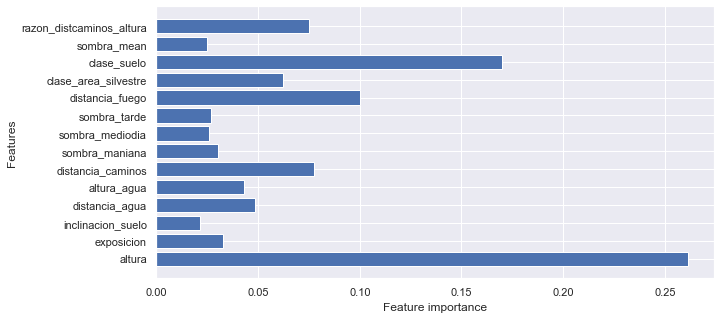

inclinacion_suelo 0.021661868869721376
sombra_mediodia 0.02562540364981683
sombra_tarde 0.027021892297615042
sombra_mean 0.02487140381807146


In [63]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = list(train_predictors.columns)

fig = plt.figure(figsize = (10, 5))
 
#Gráfico de barras
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()



###### Observaciones
Las variables con mayor feature importance son altura y clase_suelo, dos de las features con mayor correlación con el target.

¿Por qué clase_area_silvestre no tiene mucha importancia a pesar de ser la más correlacionada con el target?

Sorpresivamente, la variable razon_distcaminos_alturas resultó con una relativa importancia. Pero no es el caso de sombra_mean.

Podría eliminar directamente las variables que tienen menor feature importance, pero antes hay que tener en cuenta que el método para calcular feature importance se basa en calcular the mean and standard deviation of accumulation of the impurity decrease within each tree. Warning: Impurity-based feature importances can be misleading for high cardinality features (many unique values). Tal es el caso de clase_suelo que tiene 40 valores únicos correspondientes a 40 categorías distintas.

Al final no pude usar permutation_importance debido a que le tomó mucho tiempo correr

In [59]:
# from sklearn.inspection import permutation_importance

# r = permutation_importance(grid_search.best_estimator_, train_predictors, train_target, n_repeats=30, random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{data.feature_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")


KeyboardInterrupt: 

###### Observaciones


In [66]:
#Elimino las variables con importancia menor a 0.03 y entreno el modelo con los mejores parámetros encontrados anteriormente.
threshold = 0.03

train_predictors_reduced = train_predictors.copy()
for feature, importance in zip(features, feature_importances):
    if(importance < threshold):
        print("Eliminé la feature: ", feature, " con una feature importance de ", importance)
        train_predictors_reduced = train_predictors_reduced.drop(columns = [feature])



Eliminé la feature:  inclinacion_suelo  con una feature importance de  0.021661868869721376
Eliminé la feature:  sombra_mediodia  con una feature importance de  0.02562540364981683
Eliminé la feature:  sombra_tarde  con una feature importance de  0.027021892297615042
Eliminé la feature:  sombra_mean  con una feature importance de  0.02487140381807146
<class 'pandas.core.frame.DataFrame'>
Int64Index: 371848 entries, 357203 to 121958
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   altura                    371848 non-null  int64  
 1   exposicion                371848 non-null  int64  
 2   distancia_agua            371848 non-null  int64  
 3   altura_agua               371848 non-null  int64  
 4   distancia_caminos         371848 non-null  int64  
 5   sombra_maniana            371848 non-null  int64  
 6   distancia_fuego           371848 non-null  int64  
 7   clase_area_silvestre  

In [69]:
#Evalúo el score del modelo con los mejores parámetros
RFmodel_score = cross_val_score(grid_search.best_estimator_, train_predictors, train_target,scoring="neg_mean_squared_error", cv=5)
display_scores(np.sqrt(-RFmodel_score))

Scores: [0.46807448 0.46123056 0.46672237 0.45611805 0.4708559 ]
Mean: 0.4646002722616652
Standard deviation: 0.005272749108679821


In [82]:
#Fiteo el modelo con una menor cantidad de variables
#Mejores parámetros
RF_best_params = grid_search.best_estimator_.get_params()

#Modelo reducido
RFmodel_reduced = RandomForestClassifier()
RFmodel_reduced.set_params(**RF_best_params);

#RFmodel_reduced.fit(train_predictors_reduced, train_target)

#Evalúo el score del modelo con los mejores parámetros y una menor cantidad de variables
RFmodel_reduced_score = cross_val_score(RFmodel_reduced, train_predictors_reduced, train_target,scoring="neg_mean_squared_error", cv=5)
display_scores(np.sqrt(-RFmodel_reduced_score))


Scores: [0.42687705 0.42357259 0.43952558 0.42972116 0.43562591]
Mean: 0.4310644578247797
Standard deviation: 0.005794208649077319


##### Observaciones

Se obtuvo un mejor rendimiento (menor score mean pero ligeramente mayor standard deviation) empleando una menor cantidad de variables. Para proceder formalmente, la variable threshold, que indica el límite de feature importance debajo del cual se elimina determinada feature, debería ser considerada un hiperparámetro y hacer grid search nuevamente.

In [ ]:
#El mejor modelo de Random Forest es
RFmodel_final = RFmodel_reduced.fit(train_predictors_reduced, train_target)


#### XGBoost

##### Modelo simple con parámetros por default

In [84]:
from xgboost import XGBClassifier

XGBmodel = XGBClassifier()
XGBmodel.fit(train_predictors, train_target);

c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:41:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


##### Métricas del modelo

In [85]:
#Error sobre el train set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

XGBmodel_mse = mean_squared_error(train_target, XGBmodel.predict(train_predictors))
XGBmodel_smse = np.sqrt(XGBmodel_mse)
print("Square of Mean Square Error: ", XGBmodel_mse )

XGBmodel_mae = mean_absolute_error(train_target,XGBmodel.predict(train_predictors))
print("Mean Absolute Error: ", XGBmodel_mae )


Square of Mean Square Error:  0.33705976635614554
Mean Absolute Error:  0.15446903035648976


###### Observaciones

##### Cross Validation

In [41]:
train_predictions = XGBmodel.predict(train_predictors)
scores = cross_val_score(XGBmodel, train_predictors, train_target,scoring="neg_mean_squared_error", cv=5) #cv es la cantidad de particiones
display_scores(np.sqrt(-scores))


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:25:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:27:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:28:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:31:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores: [0.66209946 0.67349601 0.68409385 0.67278142 0.68116345]
Mean: 0.6747268386559704
Standard deviation: 0.007667090605752084


###### Observaciones

##### Grid Search

¿Qué parámetros se pueden variar en XGBoost? Hago una lista de los parámetros, junto a una breve explicación, el valor por default y el rango en el que voy a variar cada uno de ellos al hacer grid search
1. n_estimators = 100 (number of trees) (target 500-1000)
* Default: 100
* Variación: 100
2. eta (a.k.a. learning rate)
* Default: 0.3
* Variación: [0.1, 0.3, 0.5, 0.8]
3. max_depth: max depth del tree
* Default: 6
* Variación: [3, 6, 12, 24] 
4. min_samples_split = 2
* Default: 2
* Variación: 2
5. min_samples_leaf = 1
* Default: 1
* Variación: 1
6. subsample: Subsample ratio of the training instances. Entiendo que en cada instancia de training no usa todos los datos de train, sino una parte de ellos. Esto previene el overfitting.
* Default: 1
* Variación: [0.5, 0.75, 1.0]
7. colsample_bytree: subsample ratio of columns when constructing each tree. Entiendo que es el subsample de features que considera para hacer splits en el entrenamiento de un árbol. Si esto es así significaría que estaría haciendo un random forest?
* Default: 1  
* Variación: 1 
8. gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
* Default: 0
* Variación: [0.1, 0.5, 1]  

Los siguientes parámetros son útiles para XGB pero solo para modelos de regresión, no para classifier.
9. alpha: L1 regularization term on weights. Un aumento de este valor produce un modelo más conservativo. A diferencia de L2, le da menor peso a los outliers
* Default: 0
* Variación: [0, 0.5, 1]
10. lambda: L2 regularization term on weights. Un aumento de este valor produce un modelo más conservativo. Pesa mucho los outliers.
* Default: 0
* Variación: [0, 0.5, 1]

In [86]:
#Quiero ver si los parámetros n_estimators, min_samples_split y min_samples_leaf están definidos para XGBClassifier:
XGBmodel = XGBClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1)

In [87]:
#Defino los parámetros que voy a variar
# param_grid = [
#     {'eta': [0.1, 0.3, 0.5, 0.8], 'max_depth':[3, 6, 12, 24], 'subsample':[0.5, 0.75, 1.0], 'colsample_bytree':[0.4, 0.6, 0.8, 1.0], 'gamma': [0.1, 1, 5, 20]},
#   ]

param_grid = [
    {'max_depth':[3, 6, 12, 24]},
  ]


#Defino el modelo
XGBmodel_GS = XGBClassifier()

grid_search = GridSearchCV(XGBmodel_GS, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 3); #verbose = 3 muestra el progreso a medida que se hace el gridsearch. Es útil cuando tengo que hacer corridas largas.

grid_search.fit(train_predictors, train_target)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END .max_depth=3;, score=(train=-0.985, test=-0.999) total time=  38.6s


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:48:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END .max_depth=3;, score=(train=-1.030, test=-1.077) total time=  40.1s


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END .max_depth=3;, score=(train=-0.995, test=-1.037) total time=  40.3s


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:49:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END .max_depth=3;, score=(train=-0.992, test=-1.011) total time=  44.1s


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:50:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END .max_depth=3;, score=(train=-1.006, test=-1.034) total time=  47.5s


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:51:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END .max_depth=6;, score=(train=-0.317, test=-0.438) total time= 1.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:52:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END .max_depth=6;, score=(train=-0.329, test=-0.454) total time= 1.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:54:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END .max_depth=6;, score=(train=-0.328, test=-0.468) total time= 1.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:56:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END .max_depth=6;, score=(train=-0.318, test=-0.453) total time= 1.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:57:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END .max_depth=6;, score=(train=-0.321, test=-0.464) total time= 1.4min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:59:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END max_depth=12;, score=(train=-0.001, test=-0.188) total time= 2.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:02:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END max_depth=12;, score=(train=-0.001, test=-0.189) total time= 2.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:05:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END max_depth=12;, score=(train=-0.002, test=-0.190) total time= 3.0min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:08:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END max_depth=12;, score=(train=-0.002, test=-0.181) total time= 2.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:11:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END max_depth=12;, score=(train=-0.001, test=-0.193) total time= 2.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:13:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END max_depth=24;, score=(train=-0.000, test=-0.170) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:18:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END max_depth=24;, score=(train=-0.000, test=-0.171) total time= 4.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:23:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END max_depth=24;, score=(train=-0.000, test=-0.170) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:28:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END max_depth=24;, score=(train=-0.000, test=-0.162) total time= 4.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:32:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END max_depth=24;, score=(train=-0.000, test=-0.185) total time= 4.7min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:37:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [88]:
print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Los mejores parámetros son: {'max_depth': 24}
El score de cada combinación de hiperparámetros es:
1.0157083370288922 {'max_depth': 3}
0.6747703987883854 {'max_depth': 6}
0.4337960738513713 {'max_depth': 12}
0.4142297049418946 {'max_depth': 24}


##### Observaciones

Afronto Cross Validation de igual manera que para Random Forest. No se tuvieron en cuenta muchas variaciones de parámetros debido a que al gran tiempo de ejecución necesario para entrenar XGBoost en relación a RandomForest.

1. Experimento 01:
param_grid = [
    {'max_depth':[3, 6, 12, 24]},
  ]

Dejo todos los parámetros por default salvo
* max_depth :[3, 6, 12, 24]
Se obtuvo como mejor parámetro max_depth: 
con un score de ~
El mayor score obtenido fue de ~
correspondiente a max_depth: 

Los mejores parámetros son: {'max_depth': 24}
El score de cada combinación de hiperparámetros es:
1.0157083370288922 {'max_depth': 3}
0.6747703987883854 {'max_depth': 6}
0.4337960738513713 {'max_depth': 12}
0.4142297049418946 {'max_depth': 24}


2. Experimento 02:
param_grid = [
    {'eta': [0.1, 0.3, 0.5], 'max_depth':[10]},
  ]
Se dejaron todos los parámetros por default salvo
* max_depth: 10
* eta: [0.1, 0.3, 0.5]
Se obtuvo como mejor parámetro eta:
con un score de ~
El mayor score obtenido fue de ~
correspondiente a eta: 



##### Conclusiones
* A mayor max_depth, mejor rendimiento tiene el modelo. Este comportamiento también se observó en RandomForest
* Mayor eta no es sinónimo de menor score. 



3. Experimento 03:
param_grid = [
    {'eta': [0.1, 0.3, 0.5, 0.8], 'max_depth':[10]}, 'subsample':[0.75, 1.0], 'gamma': [0, 0.1]
  ]
En base a lo anterior, hago grid search alrededor de los mejores parámetros encontrados:








In [89]:
#Experimento 02:

param_grid = [
    {'eta': [0.1, 0.3, 0.5], 'max_depth':[10]},
  ]
#Defino el modelo
XGBmodel_GS = XGBClassifier()

grid_search = GridSearchCV(XGBmodel_GS, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 3); #verbose = 3 muestra el progreso a medida que se hace el gridsearch. Es útil cuando tengo que hacer corridas largas.

grid_search.fit(train_predictors, train_target)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:46:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.1, max_depth=10;, score=(train=-0.197, test=-0.352) total time= 2.1min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:48:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.1, max_depth=10;, score=(train=-0.196, test=-0.360) total time= 2.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:50:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.1, max_depth=10;, score=(train=-0.191, test=-0.359) total time= 2.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:52:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.1, max_depth=10;, score=(train=-0.189, test=-0.352) total time= 2.3min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:55:17] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.1, max_depth=10;, score=(train=-0.194, test=-0.374) total time= 2.5min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:57:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END eta=0.3, max_depth=10;, score=(train=-0.018, test=-0.205) total time= 2.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:00:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END eta=0.3, max_depth=10;, score=(train=-0.018, test=-0.205) total time= 2.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:03:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END eta=0.3, max_depth=10;, score=(train=-0.020, test=-0.220) total time= 2.9min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:05:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END eta=0.3, max_depth=10;, score=(train=-0.019, test=-0.208) total time= 2.8min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:08:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END eta=0.3, max_depth=10;, score=(train=-0.018, test=-0.220) total time= 2.6min


c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\ProgramData\Anaconda3\envs\Introduccion_al_ML_IB\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:11:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#Experimento 02:

print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#Experimento 03:

param_grid = [
    {'eta': [0.3, 0.5], 'max_depth':[20, 40, 60], 'subsample':[0.75, 1.0], 'gamma': [0, 0.1]},
  ]
#Defino el modelo
XGBmodel_GS = XGBClassifier()

grid_search = GridSearchCV(XGBmodel_GS, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 3); #verbose = 3 muestra el progreso a medida que se hace el gridsearch. Es útil cuando tengo que hacer corridas largas.

grid_search.fit(train_predictors, train_target)



In [ ]:
#Experimento 03:

print("Los mejores parámetros son:",grid_search.best_params_)

#Resultados de cada combinación de hiperparámetros
print("El score de cada combinación de hiperparámetros es:")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#Uso los mejores parámetros encontrados para entrenar el modelo final de XGB:
#Mejores parámetros
XGB_best_params = grid_search.best_estimator_.get_params()

XGBmodel_final = XGBClassifier();
XGBmodel_final.set_params(**XGB_best_params);
XGBmodel_final.fit(train_predictors, train_target);


#### Feature Importances

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
features = list(train_predictors.columns)

fig = plt.figure(figsize = (10, 5))
 
#Gráfico de barras
plt.barh(features, feature_importances)
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()


##### Observaciones

A diferencia del Random Forest no se realizó un nuevo modelo con una menor cantidad de variables debido al gran tiempo de ejecución requerido

#### MEJOR MODELO

In [ ]:
final_model = 

#### Evalúo test con el mejor modelo

In [ ]:
#Calculo el error del modelo sobre el test set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


#Calculamos distintas Performance metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

model_final_accuracy = accuracy_score(test_target, RFmodel.predict(test_predictors))
print("Accuracy del modelo: ", model_final_accuracy*100, " %")

model_final_precision = precision_score(test_target, RFmodel.predict(test_predictors))
print("Precision del modelo: ", model_final_precision*100, " %")

model_final_recall = recall_score(test_target, RFmodel.predict(test_predictors))
print("Recall del modelo: ", model_final_recall*100, " %")



# #Para evaluar el test sobre Random Forest con las nuevas variables tengo que
# #(1) Crear las nuevas variables
# #(2) Dividir el test_set entre test_predictors y test_target
# sombra_mean = (test_set["sombra_maniana"] + test_set["sombra_mediodia"] + test_set["sombra_tarde"])/3
# test_set["sombra_mean"] = sombra_mean

# razon_distcaminos_altura = test_set["distancia_caminos"]/test_set["altura"]
# test_set["razon_distcaminos_altura"] = razon_distcaminos_altura

# test_predictors = test_set.drop("dosel_forestal", axis=1)
# test_target = test_set["dosel_forestal"].copy()

# RFmodel_mse = (test_target,RFmodel.predict(test_predictors))
# print("Mean Square Error: ", RFmodel_mse )

# RFmodel_mae = mean_absolute_error(test_target,RFmodel.predict(test_predictors))
# print("Mean Absolute Error: ", RFmodel_mae )



0.20065187926249436

#### Exporto el modelo

In [ ]:
with open("final_model.p","wb") as f:
    pickle.dump(final_model,f)